In [1]:
import cajal.sample_swc
import cajal.swc
from os.path import join

In [2]:
bd = "/Users/apple/Desktop/KLin_Group/Project_2024/data/Was2CODE_analysis_turbo/" # Base directory

In [3]:
join(bd, 'swc_bdad_100pts_euclidean_node_types.npy')

'/Users/apple/Desktop/KLin_Group/Project_2024/data/Was2CODE_analysis_turbo/swc_bdad_100pts_euclidean_node_types.npy'

We sample 100 points from each neuron's outline and compute the Euclidean distance between each pair of points in that neuron

In [4]:
cajal.sample_swc.compute_icdm_all_euclidean(
    infolder=join(bd, 'swc'),
    out_csv=join(bd, 'swc_bdad_100pts_euclidean_icdm.csv'),
    preprocess=cajal.swc.preprocessor_eu(
        structure_ids=[1,3,4],
        soma_component_only=False),
    n_sample=100)

100%|█████████▉| 508/509 [03:28<00:00,  2.44it/s]


[]

Compute the Gromov-Wasserstein distance between each pair of neurons.

In [5]:
import cajal.run_gw

cajal.run_gw.compute_gw_distance_matrix(
    join(bd, 'swc_bdad_100pts_euclidean_icdm.csv'),
    join(bd, 'swc_bdad_100pts_euclidean_GW_dmat.csv'),
    num_processes=15,
    gw_coupling_mat_csv_loc=join(bd, 'swc_bdad_100pts_euclidean_GW_couplings.csv')  
)

  0%|          | 0/129286 [00:00<?, ?it/s]

(array([[ 0.        , 64.95115685, 25.70739074, ..., 15.61975611,
         24.23737442, 16.51601302],
        [64.95115685,  0.        , 53.69570946, ..., 76.25817075,
         47.42066104, 74.13320373],
        [25.70739074, 53.69570946,  0.        , ..., 36.03413034,
         28.43290168, 36.73803648],
        ...,
        [15.61975611, 76.25817075, 36.03413034, ...,  0.        ,
         32.0332959 ,  9.90406728],
        [24.23737442, 47.42066104, 28.43290168, ..., 32.0332959 ,
          0.        , 31.60357771],
        [16.51601302, 74.13320373, 36.73803648, ...,  9.90406728,
         31.60357771,  0.        ]]),
 None)

If you reopen the file, you already have all the calculated files

In [9]:
import os
from os.path import join
import cajal.utilities

# Reset base directory
bd = "/Users/apple/Desktop/KLin_Group/Project_2024/data/Was2CODE_analysis_turbo/"

# Load existed file
icdm_csv = join(bd, 'swc_bdad_100pts_euclidean_icdm.csv')
gw_dmat_csv = join(bd, 'swc_bdad_100pts_euclidean_GW_dmat.csv')
gw_coupling_csv = join(bd, 'swc_bdad_100pts_euclidean_GW_couplings.csv')

# load GW distance matrix
cells, gw_dist_dict = cajal.utilities.read_gw_dists(gw_dmat_csv, header=True)
gw_dist = cajal.utilities.dist_mat_of_dict(gw_dist_dict, cells)

We can visualize the resulting space of cell morphologies using UMAP:

In [7]:
import nbformat
print(nbformat.__version__)


5.10.4


In [8]:
import plotly.io as pio

# Choose the adequate plotly renderer for visualizing plotly graphs in your system

\


import cajal.utilities
from umap import umap_
import plotly.express

# Read GW distance matrix
cells, gw_dist_dict = cajal.utilities.read_gw_dists(join(bd,"swc_bdad_100pts_euclidean_GW_dmat.csv"), header=True)
gw_dist = cajal.utilities.dist_mat_of_dict(gw_dist_dict, cells)

# Compute UMAP representation
reducer = umap_.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)

# Visualize UMAP
fig=plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       template="simple_white",
                       hover_name=[m + ".swc" for m in cells])
fig.show()


/Users/apple/miniconda3/envs/cajal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/apple/miniconda3/envs/cajal/lib/python3.9/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/apple/miniconda3/envs/cajal/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


we use the Leiden algorithm to cluster the neurons based on their morphology

In [10]:
clusters = cajal.utilities.leiden_clustering(gw_dist, seed=1)
plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       template="simple_white",
                       hover_name=[m + ".swc" for m in cells],
                       color = [str(m) for m in clusters])

visualize some of the cells in the brown cluster (cluster 8) using the Python package NAVis

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

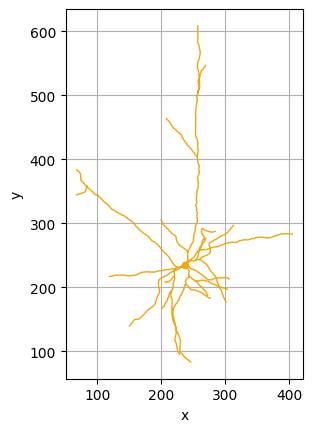

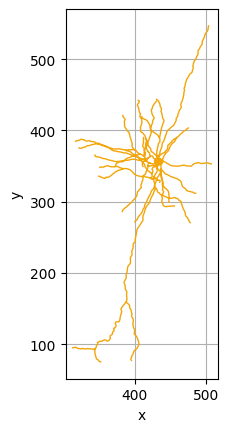

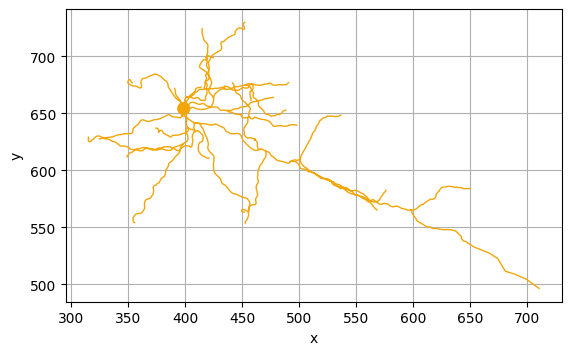

In [11]:
import navis

cells_cluster_8 = [n for m, n in zip(clusters, cells) if m==8]
cluster_8 = [navis.read_swc(join(bd,"swc/" + n + ".swc")) for n in cells_cluster_8]

cluster_8[1].plot2d()
cluster_8[2].plot2d()
cluster_8[3].plot2d()

We can also compute the medoid of the cluster (most central neuron of the cluster, good representative of the morphologies present in the cluster)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

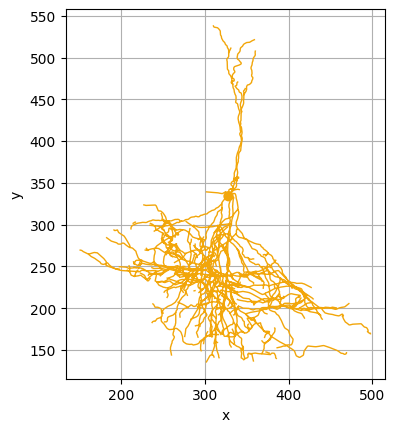

In [12]:
medoid_8 = navis.read_swc(join(bd,'swc/' + cajal.utilities.identify_medoid(cells_cluster_8, gw_dist_dict) + ".swc"))
medoid_8.plot2d()

visualize the components of each neuron which contribute the most to the overall morphological distance.
Regions in red represent morphological distinctions between the two cells.

In [13]:
from cajal.deformation_vis import navis_heatmap

cells_cluster_5 = [n for m, n in zip(clusters, cells) if m==5]
medoid_5 = navis.read_swc(join(bd,'swc/' + cajal.utilities.identify_medoid(cells_cluster_5, gw_dist_dict) + ".swc"))
(heatmap_5, heatmap_8) = navis_heatmap(medoid_5, 200, medoid_8, 200)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

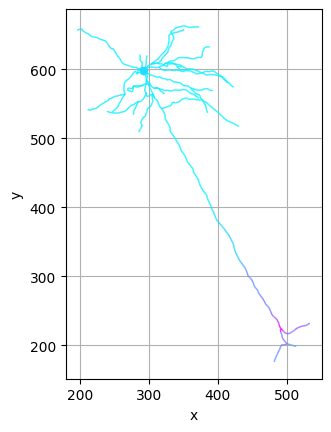

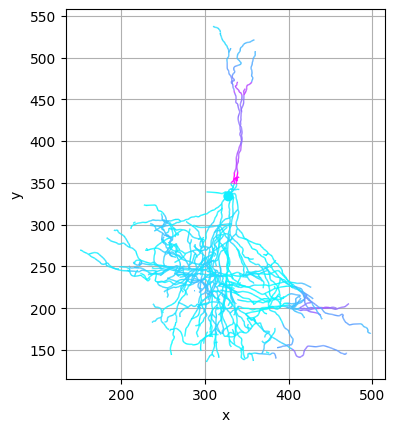

In [14]:
heatmap_5.plot2d(color_by='distortion', palette='cool')
heatmap_8.plot2d(color_by='distortion', palette='cool')

Generating and visualizing a representative tree of this cluster, and give intuition into the basic commonalities in this cluster

Using “average spanning tree” algorithm

In [15]:
import cajal.utilities
print(dir(cajal.utilities))


['Err', 'Generic', 'Iterable', 'Iterator', 'NearestNeighbors', 'Optional', 'T', 'TypeVar', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'avg_shape', 'avg_shape_spt', 'cap', 'community_louvain', 'coo_array', 'coo_matrix', 'csv', 'dataclass', 'dijkstra', 'dist_mat_of_dict', 'identify_medoid', 'ig', 'it', 'knn_graph', 'leiden_clustering', 'leidenalg', 'louvain_clustering', 'np', 'npt', 'nx', 'orient', 'read_gw_couplings', 'read_gw_dists', 'read_gw_dists_pd', 'squareform', 'step_size', 'write_csv_block']


In [23]:
gw_coupling_mat_dict = cajal.utilities.read_gw_couplings(
    join(bd, 'swc_bdad_100pts_euclidean_GW_couplings.csv'),
    header=True
)

cell_icdms = dict(cajal.utilities.cell_icdm_iterator_csv(
    join(bd, 'swc_bdad_100pts_euclidean_icdm.csv'),
    as_squareform=False
))

def plot_graph(adjacency_matrix, confidence):
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np
    G=nx.Graph(adjacency_matrix, confidence=confidence)
    pos = nx.spring_layout(G)
    color = np.arange(len(G.nodes))
    plot_color = color[[i[1] for i in G.edges]]
    _, ax = plt.subplots()
    nx.draw_networkx_edges(G, pos, alpha=1, width=2, ax=ax, edge_color=plot_color)
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=color, node_size=2, ax=ax)
    plt.show()

(adjacency_matrix, confidence) = cajal.utilities.avg_shape_spt(
    [n for m, n in zip(clusters, cells) if m==0],
    gw_dist_dict,
    cell_icdms,
    gw_coupling_mat_dict,
    k=3)

plot_graph(adjacency_matrix, confidence)

AttributeError: module 'cajal.utilities' has no attribute 'cell_icdm_iterator_csv'

In [19]:
import pandas

metadata = pandas.read_csv(join(bd,"cell_types_specimen_details.csv"))
metadata.index = [str(m) for m in metadata["specimen__id"]]
metadata = metadata.loc[cells]

plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       template="simple_white",
                       hover_name=[m + ".swc" for m in cells],
                       color = metadata["structure__layer"])

In [20]:
import cajal.laplacian_score
import numpy
import pandas
from scipy.spatial.distance import squareform

# Build indicator matrix
layers = numpy.unique(metadata["structure__layer"])
indicator = (numpy.array(metadata["structure__layer"])[:,None] == layers)*1

# Compute the Laplacian score
laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(indicator,
                                       gw_dist,
                                       numpy.median(squareform(gw_dist)),
                                       permutations = 5000,
                                       covariates = None,
                                       return_random_laplacians = False)[0])
laplacian.index = layers

print(laplacian)

     feature_laplacians  laplacian_p_values  laplacian_q_values
1              0.976417            0.000200            0.000480
2/3            0.968974            0.000200            0.000480
4              0.969925            0.000200            0.000480
5              0.987595            0.000200            0.000480
6a             0.992887            0.002200            0.002639
6b             0.992448            0.002799            0.002799


In [25]:
indicator

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cre_lines = numpy.array(metadata["line_name"])

clf = KNeighborsClassifier(metric="precomputed", n_neighbors=10, weights="distance")
cv = StratifiedKFold(n_splits=7, shuffle=True,random_state=0)
accuracy = cross_val_score(clf, X=gw_dist, y=cre_lines,cv=cv)

numpy.mean(accuracy)

/Users/apple/miniconda3/envs/cajal/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.



0.2964231354642313

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import matthews_corrcoef

cvp = cross_val_predict(clf, X=gw_dist, y=cre_lines, cv=cv)

print(matthews_corrcoef(cvp, cre_lines))

0.24254759274161383


/Users/apple/miniconda3/envs/cajal/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.

